# Sentiment Analysis based on Reading Attention Span
This notebook extracts semantic segments from HTML files of all webpages, and calculate correponding weights based on human reading attentioen span and dacay.

### Semantic Segments Extraction

In [2]:
# install nltk if haven't: 
#   pip install nltk
# download the necessary NLTK data if haven't: 
#   nltk.download('punkt')
#   nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer, PorterStemmer 
from nltk.tokenize import word_tokenize
import nltk
from bs4 import BeautifulSoup
import os
import pandas as pd
import re
from collections import defaultdict
import json
import numpy as np
import ast

In [3]:
# Please note that the dataset is gitignored due to its size, therefore please download it from the following link:
# https://snap.stanford.edu/data/wikispeedia/wikispeedia_articles_html.tar.gz
# https://snap.stanford.edu/data/wikispeedia/wikispeedia_paths-and-graph.tar.gz
# and then put it into the dataset folder under emotion folder as following:
# ADA-2024-PROJECT-TADA2024
# ├── emotion
# │   ├── dataset
# │   │   ├── wpcd
# │   │   ├── wikispeedia_paths-and-graph

html_dir = 'dataset/wpcd/wp' 
paths_dir = 'dataset/wikispeedia_paths-and-graph/paths_finished.tsv' 

### HTML Content Preprocessing and Extraction with Hyperlink Preservation

We considered the action of \
•	Lemmatization: Reduces words to their base form (e.g., “running” to “run”). \
•	Stemming: Trims words to their root (e.g., “jumps” to “jump”).

Benefits of Lemmatization and Stemming in Sentiment Analysis

1.	Both lemmatization and stemming reduce words to a common form, which can help models by reducing vocabulary size and focusing on the base meaning of words. For instance, “amazing” and “amazingly” become “amaz,” which may help a simpler model recognize these as similar in sentiment.
2.	Reducing Noise: Variations in verb tenses or plural forms don’t usually impact sentiment. By simplifying “running,” “ran,” and “runs” to “run,” the model can better focus on the emotional content of the words rather than linguistic variations.

Drawbacks of Lemmatization and Stemming

1.	Loss of Nuance: Stemming, in particular, can lead to words losing critical distinctions. For example, “happy” and “happiness” might both be stemmed to “happi,” which removes any slight difference in meaning or intensity that could be relevant to sentiment.
2.	Complicated Sentiment Contexts: Certain suffixes can carry sentiment information. For instance, “help” (neutral) versus “helpful” (positive). Stemming might remove these subtle distinctions, potentially reducing accuracy.

However, for transformer models (e.g., BERT, RoBERTa) or when working with models trained on large datasets, as these models already account for nuanced variations. Modern models handle token variations well, and stemming can reduce performance by discarding subtle context. Therefore, lemmatization alone might be a safer choice than stemming. It preserves word meaning more accurately, while still standardizing some forms. Stemming might only be beneficial for smaller, less nuanced datasets where word reduction is crucial.

Hence, we only perform lemmatization here.


Extracts readable text from HTML content while preserving hyperlinks. The anchor tags in the HTML content will be converted to a format that includes the anchor text and URL in the form `[anchor_text](URL)`. The function splits the text into sentences to make it more aligned with natural reading behavior.

In [4]:
# Initialize lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Tokenizes and lemmatizes each word in the text.
    """
    words = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized)

def extract_text_from_html(html_content):
    """
    Extracts readable text from HTML content, preserves hyperlinks with anchor text,
    performs lemmatization and stemming, and splits it into sentences.
    """
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Process anchor tags to preserve hyperlink text and URL
    for a in soup.find_all('a', href=True):
        # Replace each anchor tag with '[anchor_text](url)' format
        a.replace_with(f"[{a.get_text()}](URL)")
    
    # Get the full text with preserved hyperlinks
    text = ' '.join(soup.stripped_strings)
    
    # Split text into sentences based on punctuation
    sentences = re.split(r'(?<=[.!?]) +', text)
    
    # Apply preprocessing (lemmatization and stemming) to each sentence
    processed_sentences = [preprocess_text(sentence) for sentence in sentences]
    
    return processed_sentences

### Processing Each HTML File and extract sentences as semantic segments
**Take Long Time, Only Run Once** This block will go through each file in the directory and organize the extracted sentences into a DataFrame. Each row in the dataframe is the sentence corpus for each webpage, and each column is a sentence after preprocessing (after lemmatisation and tag removal except the link tag).

In [6]:
df = pd.DataFrame()
extraction_path = html_dir

## Filtering Non-HTML Files
# ery file in the folder is an HTML file, so this code filters out non-HTML files 
# Only files with `.html` or `.htm` extensions are read and processed.

# Calculate total number of files for progress tracking
total_files = sum(
    len([name for name in os.listdir(os.path.join(extraction_path, folder)) if name.endswith(('.html', '.htm'))])
    for folder in os.listdir(extraction_path)
    if os.path.isdir(os.path.join(extraction_path, folder))
)

# Initialize a counter for processed files
processed_files = 0

# Process each HTML file in the folder
print("preprocessing starts")
for folder_name in os.listdir(extraction_path):
    folder_path = os.path.join(extraction_path, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            # Check if the file has an HTML extension
            if file_name.endswith(('.html', '.htm')):
                file_path = os.path.join(folder_path, file_name)
                
                # tries utf-8 encoding first and, if it fails, 
                # switches to latin-1, which can handle a wider range of byte sequences.
                try:
                    with open(file_path, 'r', encoding='utf-8') as file:
                        html_content = file.read()
                except UnicodeDecodeError:
                    with open(file_path, 'r', encoding='latin-1') as file:
                        html_content = file.read()
                
                # Process the HTML content
                sentences = extract_text_from_html(html_content)
                
                # Create a temporary DataFrame for this file
                temp_df = pd.DataFrame([sentences], index=[file_name])
                
                # Concatenate to main DataFrame
                df = pd.concat([df, temp_df])
                
                # Update and display progress
                processed_files += 1
                if processed_files % 500 == 0:
                    print(f"Processed {processed_files}/{total_files} files")

# df.head()
df.to_csv('dataset/extracted_sentences.csv', index=True)
print('preprocessing finished and sentence corpus with link tag for each webpage is save as .csv')

preprocessing starts
Processed 500/5462 files
Processed 1000/5462 files
Processed 1500/5462 files
Processed 2000/5462 files
Processed 2500/5462 files
Processed 3000/5462 files
Processed 3500/5462 files
Processed 4000/5462 files
Processed 4500/5462 files
Processed 5000/5462 files
preprocessing finished and sentence corpus with link tag for each webpage is save as .csv


In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,721,722,723,724,725,726,727,728,729,730
Royal_Marines.htm,Royal Marines Royal Marines [ 2007 Schools Wik...,Related subject : [ Military History and War ]...,A core component of the country 's Rapid Deplo...,"The high level of training and competence , co...",The Royal Marines are a component part of the ...,Role Corps of Royal Marines Cap Badge of the R...,As the United Kingdom Armed Forces ' specialis...,In common with the other armed force the Royal...,"Command , Control and Organisation Command of ...",The operational capability of the Corps compri...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Recycling.htm,Recycling Recycling [ 2007 Schools Wikipedia S...,Related subject : [ Environment ] ( URL ) [ ] ...,[ Environmental science ] ( URL ) Environmenta...,Recycling prevents useful material resource be...,Recycling is a key concept of modern [ waste m...,"Recyclable material , also called `` recyclabl...","They include [ glass ] ( URL ) , paper , [ alu...","Biodegradable waste , such a food waste or gar...",Recyclates need to be sorted and separated int...,Contamination of the recylates with other mate...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Retreat_of_glaciers_since_1850.htm,Retreat of glacier since 1850 Retreat of glaci...,Related subject : [ Climate and the Weather ] ...,"Studied by glaciologists , the temporal coinci...",Mid-latitude mountain range such a the [ Himal...,The Little Ice Age wa a period from about 1550...,"Subsequently , until about 1940 glacier around...","Glacial retreat slowed and even reversed , in ...","However , since 1980 a significant global warm...",In location such a the Andes of [ South Americ...,"The retreat of mountain glacier , notably in w...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Remember_Girls_Like_Rajpura.htm,How Remembering a Charity help [ SOS Chidren '...,She share with u her success story .,My Success Story I came to SOS Children 's Vil...,At that point I could have never thought that ...,My SOS mother wa very supportive and always en...,"After getting grade ' A ' in class eight , my ...",At school I played badminton and also particip...,"Looking at my performance in badminton , my sp...","After class twelve , I joined Guru Nanak Khals...",Hostel life wa a different experience all toge...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rutherfordium.htm,Rutherfordium Rutherfordium [ 2007 Schools Wik...,Related subject : [ Chemical element ] ( URL )...,This is a highly radioactive synthetic element...,This element therefore ha no application and l...,Rutherfordium is the first transactinide eleme...,History Rutherfordium ( named in honour of not...,Researchers there bombarded 242 [ Pu ] ( URL )...,In 1969 researcher at the University of Califo...,The UC group also stated that they could not r...,This resulted in an element naming controversy...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Attention Span Weight Calculation

### Link Attention Modelling

First we will generate a dictionary the contains the count of each linked link corresponding with each target.

Reasoning:
> To model human attention in navigation, we hypothesize that a human navigator is likely to focus more on links or titles that are relevant to their end goal, or target article. By examining real human behavioral data, we can derive a dictionary that quantifies the frequency of articles encountered on the way to each target article. This dictionary serves as an indicator of the correlation between each intermediate link/title and the target article.

> This correlation relationship gives insight into a human's inclination to choose specific links or titles based on their relevance to the target. In other words, the more frequently an article appears in paths leading to a particular target, the more likely it reflects a natural inclination or preference in human navigation behavior. The unclicked links will share the same ambigutious / preassumed inclination.

In [8]:
file_path = 'dataset/wikispeedia_paths-and-graph/paths_finished.tsv' # we only consider the finished paths
# Load the TSV file, skipping initial non-data rows and specifying column names
data = pd.read_csv(file_path, sep='\t', comment='#', header=0, names=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"])

# Initialize a dictionary to store counts for each target article
target_count_dict = defaultdict(lambda: defaultdict(int))

# Process each path to count frequencies
for path in data['path']:
    articles = path.split(';')  # Split articles in the path by ";"
    if articles:
        target_article = articles[-1]  # Last article is the target
        for article in articles[:-1]:  # Count articles leading up to the target
            target_count_dict[target_article][article] += 1

# Convert nested dictionary to a regular dictionary for display or further processing
target_count_dict = {target: dict(counts) for target, counts in target_count_dict.items()}

# Display result
print("Sample output for target articles and counts leading to each:")
for target, counts in list(target_count_dict.items())[:5]:  # Display sample for brevity
    print(f"Target Article: {target}")
    print("Counts:", counts)
    print()

output_path = 'dataset/link_freq_dict.json' # title click frequency for each target
with open(output_path, 'w') as f:
    json.dump(target_count_dict, f)

print("Dictionary saved as link_freq_dict.json")

Sample output for target articles and counts leading to each:
Target Article: African_slave_trade
Counts: {'14th_century': 2, 'Europe': 3, 'Africa': 16, 'Atlantic_slave_trade': 18, 'Niger': 1, 'Nigeria': 1, 'British_Empire': 1, 'Slavery': 8, 'Police_state': 4, 'Police': 1, 'United_States': 12, 'Washington%2C_D.C.': 2, '<': 2, 'George_Washington': 1, 'President_of_the_United_States': 2, 'United_States_Constitution': 1, 'Government': 1, 'George_W._Bush': 2, 'September_11%2C_2001_attacks': 1, 'New_York_City': 1, 'Business': 1, 'Economics': 1, 'War': 1, 'Game_theory': 1, 'Television': 1, 'Film': 1, 'Animation': 1, 'The_Lion_King': 1, 'Lion': 1, 'Mammal': 1, 'Scientific_classification': 1, 'Organism': 1, 'Life': 1, 'Energy': 1, 'Aristotle': 1, 'Ancient_Greece': 1, 'Christianity': 1, '16th_century': 1, 'Leonardo_da_Vinci': 1, 'Mona_Lisa': 1, 'Paris': 1, 'France': 1, 'Germany': 1, 'Austria': 1, 'German_language': 1, 'Liechtenstein': 1, 'Monaco': 1, 'Constitutional_monarchy': 1, 'Japan': 1, 'J

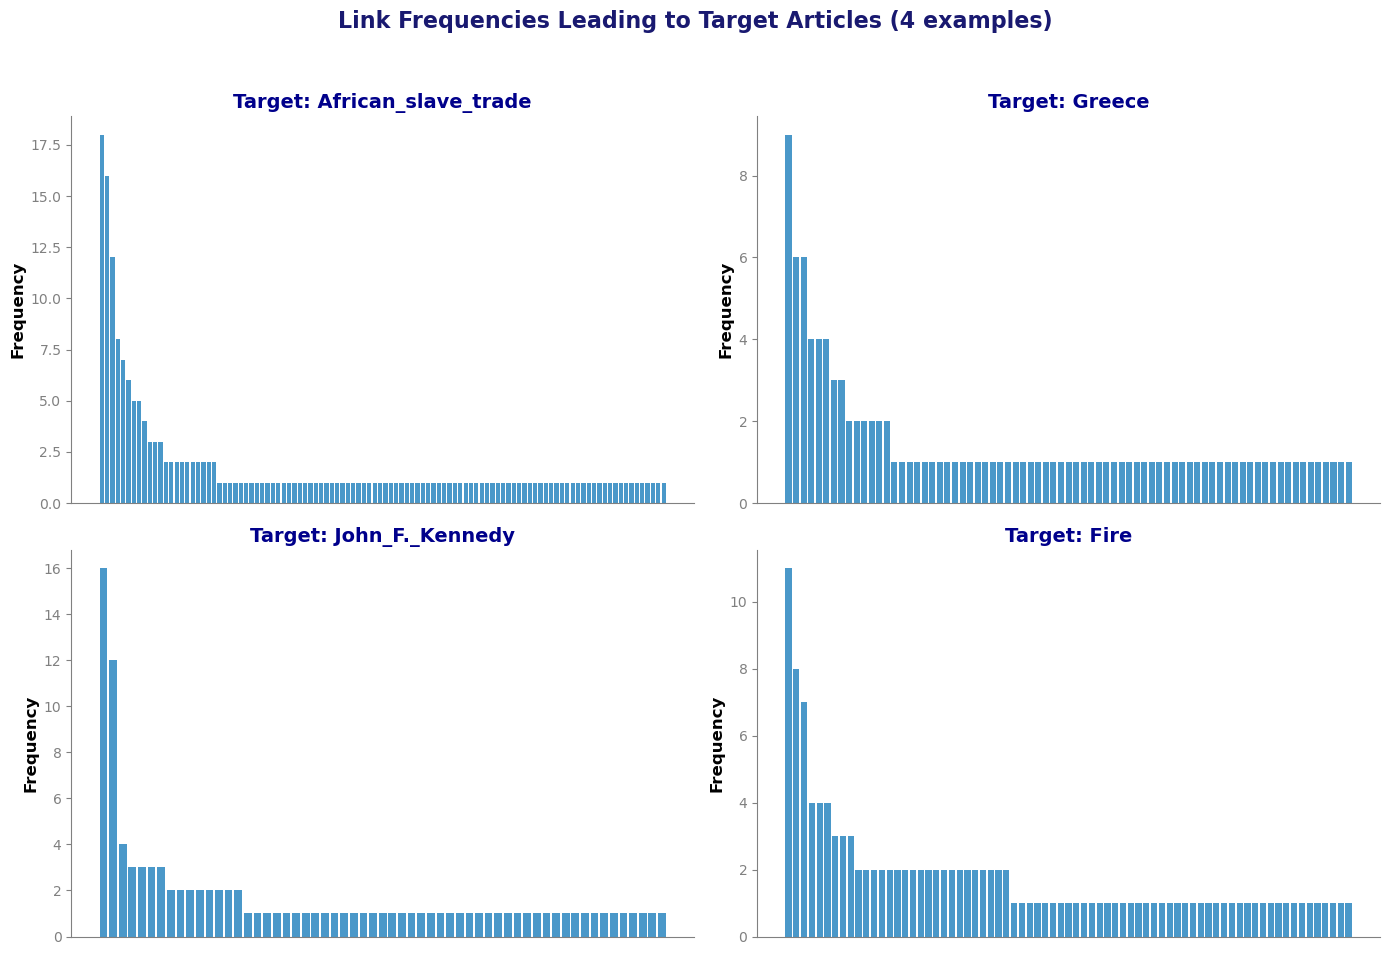

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Load the dictionary from the JSON file
json_file_path = 'dataset/link_freq_dict.json'
with open(json_file_path, 'r') as f:
    target_count_dict = json.load(f)

# Select a few target articles to visualize
sample_targets = list(target_count_dict.keys())[:4]  # Visualize the first 5 target articles for brevity

# Set up the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Link Frequencies Leading to Target Articles (4 examples)", fontsize=16, fontweight='bold', color='midnightblue')

# Color map for bar colors
colors = cm.Blues(0.6)

# Plot each target in a subplot
for i, target in enumerate(sample_targets):
    # Get articles and frequencies, sorted by frequency
    articles = list(target_count_dict[target].keys())
    frequencies = list(target_count_dict[target].values())
    sorted_data = sorted(zip(frequencies, articles), reverse=True)
    sorted_frequencies, sorted_articles = zip(*sorted_data)
    
    # Choose the subplot
    ax = axs[i // 2, i % 2]
    bars = ax.bar(sorted_articles, sorted_frequencies, color=colors)
    
    # Styling
    ax.set_title(f"Target: {target}", fontsize=14, fontweight='semibold', color='darkblue')
    ax.set_ylabel("Frequency", fontsize=12, fontweight='semibold')
    ax.set_xticks([])  # Hide x-axis labels for clarity
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    ax.tick_params(axis='y', colors='grey')

# Adjust layout for a clean look
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the main title
plt.show()

Exponential Distribution of Frequencies: 
 
In each target’s subplot, the frequencies of articles leading to the target display an exponential-like property: a small number of articles have high frequencies, while most other articles appear less frequently. This indicates that users tend to follow a few common paths when navigating to a target, suggesting a strong preference for specific links that are likely perceived as highly relevant to the end goal.

### Sentence Weight Assignment

To model user attention, we assume that users are more likely to focus on links within sentences, as these links serve as potential pathways to reach their target. Therefore, sentences containing links (`[ anchor_text ] ( URL )`) are assigned relatively higher weights than those without links, which share a baseline weight.

In addition, we use link click frequency as an indicator of the attention drawn by each link. Links that have been clicked more frequently are likely to be perceived as more relevant or interesting, indicating a higher level of attention from users. Consequently, the weight for each link is proportional to its click frequency, and links with higher click frequencies are assigned greater weights than those with no recorded clicks.

The weight assignment method is formalised as following:

> Mathematical Expression for Sentence Weight Assignment

To model sentence weight based on link presence and click frequency, we define the following:

1. Let $S$ be a sentence.
2. Let $L_i$ represent each link in sentence $S$, where $i = 1, 2, \ldots, n$ (if there are $n$ links in the sentence).
3. Let $f(L_i)$ denote the click frequency of link $L_i$.
4. Let $W_{baseline}$ represent the baseline weight assigned to sentences with no links.

> Weight Assignment Formula

The weight $W(S)$ for sentence $S$ is assigned as follows:

1. **If $S$ contains no links**, assign a baseline weight:
   $$
   W(S) = W_{\text{baseline}}
   $$

2. **If $S$ contains links**, the weight of $S$ is calculated based on a normalized sum of the click frequencies for the links in $S$:
   $$
   W(S) = W_{\text{baseline}} + k \cdot \sum_{i=1}^n \frac{f(L_i)}{\text{\#links for target}}
   $$
   where:
   - $W_{\text{baseline}}$ is the baseline weight for sentences without links.
   - $k$ is a proportionality constant that scales the contribution of click frequency to the overall sentence weight.
   - $f(L_i)$ represents the click frequency of link $L_i$.
   - $\text{\#links for target}$ is the total sum of click frequencies for all links leading to the specified target.


> Explanation of the Formula

- **Baseline Weight $W_{\text{baseline}}$**: Ensures that every sentence has a minimum weight, even if it contains no links.
- **Click Frequency Contribution**: The term $\sum_{i=1}^n k \cdot f(L_i)$ increases the weight for sentences containing links based on how frequently those links are clicked. The higher the frequency $f(L_i)$ for a link, the greater the weight for the sentence, reflecting increased user attention.
- **Normalization Term $\frac{f(L_i)}{\text{\#links for target}}$**: Each link’s frequency $f(L_i)$ is divided by the total click frequency for the target, ensuring that frequencies are comparable across targets with varying link counts.
- **Scaled Contribution**: The normalized click frequencies are scaled by $k$ and summed for each link in the sentence, providing an overall attention weight that reflects user focus based on link relevance and frequency.


This formula prioritizes sentences with high-frequency links, aligning with the assumption that frequently clicked links draw more user attention.

Relevant literature that justifies the choice above: 
> Kahneman, D. (1973). Attention and Effort. Prentice-Hall. This classic work emphasizes that attention is a limited resource and is selectively allocated to elements that are most informative or engaging.

Proportionality Constant ( $k$ ): This value ensures that while links with high click frequencies (popular or frequently chosen links) increase sentence weight significantly, the scaling remains moderate to reflect that human attention, even when selectively focused, tends to spread across multiple cues rather than concentrating exclusively on a single feature.

> Treisman, A. M., & Gelade, G. (1980). A feature-integration theory of attention. Cognitive Psychology, 12(1), 97-136. This study suggests that attention is directed based on feature saliency, but that it distributes across multiple features, particularly in complex tasks.

In [10]:
# Load the click frequencies JSON file
with open('dataset/link_freq_dict.json', 'r') as f:
    click_frequencies = json.load(f)

# Parameters for weight calculation
W_baseline = 0.2  # Baseline weight for sentences without links
k = 0.05        # Proportionality constant for scaling click frequency contribution

# Function to calculate the weight of a sentence given a target
def calculate_sentence_weight(sentence, target, W_baseline=0.2, k=0.05):
    # Find all links in the format [ anchor_text ] ( URL ) 
    links = re.findall(r'\[\s*.*?\s*\]\s*\(\s*URL\s*\)', sentence)
    
    # If no links are found, return baseline weight
    if not links:
        return W_baseline
    
    # Retrieve the click frequencies for the given target
    target_clicks = click_frequencies.get(target, {})
    
    # Calculate the total number of links for the target to normalize
    total_links_for_target = sum(target_clicks.values()) if target_clicks else 1  # Avoid division by zero
    
    # Calculate normalized weight as baseline plus scaled sum of normalized click frequencies
    link_weight_sum = sum((target_clicks.get(link, 0) / total_links_for_target) for link in links)
    weight = W_baseline + k * link_weight_sum
    return weight

## Handling Backtracking in Path Analysis: Considerations for Emotional Analysis

In analyzing navigation paths, we must consider how to handle backtracking steps (represented by `<`). Backtracking occurs when users navigate back to a previous article, which can provide valuable insights into their exploratory behavior but may also introduce noise. Here, we explore two approaches: **removing backtracking** and **replacing backtracking with the previous article**. Each approach has unique implications for emotional analysis and the relationship between emotion change and semantic distance.

### 1. Removing Backtracking
In this approach, all instances of `<` are removed from the path, resulting in a streamlined path sequence without backtracking steps.

**Pros**:
- **Cleaner Path Sequence**: Removing backtracking provides a straightforward path, showing only forward progression. This is beneficial when the focus is on direct associations between consecutive articles.
- **Simplified Emotional Analysis**: Without backtracking, emotional analysis can focus purely on the progression of emotions as users encounter new topics. This can make patterns in emotion change easier to identify and analyze.

**Cons**:
- **Loss of Exploration Behavior**: By removing backtracking, we lose information about the user’s exploratory behavior, which might be relevant to understanding emotional responses to content revisitation.
- **Potential Loss of Emotional Nuance**: Backtracking could indicate repeated exposure to emotionally charged topics. Without it, we might miss certain patterns in emotional reactions tied to revisiting previously encountered topics.

### 2. Replacing Backtracking with the Previous Article
In this approach, each `<` is replaced with the last visited article, effectively duplicating articles in the path to indicate when users revisit content.

**Pros**:
- **Insight into Exploratory Patterns**: This approach preserves the user’s backtracking behavior, which may reveal exploratory or confirmatory patterns. These patterns could indicate deeper engagement with certain topics or themes.
- **Enhanced Emotional Analysis**: Repeated articles in the path allow us to track emotional responses to revisited content, which might reflect sustained or heightened emotions. For example, revisiting a topic with strong emotional content could amplify or stabilize the user’s emotional state.

**Cons**:
- **Increased Path Complexity**: Backtracking introduces additional steps in the path, which could complicate the analysis by increasing the number of steps and potentially diluting clear patterns in emotional progression.
- **Potential Noise in Emotional Trends**: If users frequently backtrack to neutral or less significant content, it could introduce noise in emotional trends, making it harder to distinguish meaningful emotional changes.

### Relationship Between Emotion Change and Semantic Distance

The choice between removing or preserving backtracking also impacts the analysis of **emotion change in relation to semantic distance** between articles:
- **Removing Backtracking** emphasizes the semantic distance between new topics, allowing us to examine how emotional responses shift with each novel topic encountered.
- **Preserving Backtracking** captures both semantic proximity (revisiting the same topic) and changes over time, allowing for a more detailed study of how repeated exposure to specific content influences emotion.

By analyzing emotion change in conjunction with semantic distance, we can assess how users’ emotions evolve as they navigate through increasingly different (or similar) topics. This approach could reveal patterns such as emotional intensification with greater semantic distance or stabilization with repeated exposure.

In summary, each approach offers unique insights, and the best choice depends on the focus of the analysis:
- **Without Backtracking** is ideal for studying direct emotional progression across diverse topics.
- **With Backtracking** is suitable for understanding how emotional responses are influenced by topic revisitation and exploratory behavior.

In [11]:
# Load the CSV file containing the paths
file_path = 'dataset/wikispeedia_paths-and-graph/paths_finished.tsv'  # Update with your actual file path
data = pd.read_csv(file_path, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
# print(data['path'])
data = data.dropna(subset=['path'])

# Function to extract and format path data, handling backtracking based on the chosen mode
def extract_path_data(data, handle_backtracking='remove'):
    path_data = []
    for path in data['path']:
        articles = path.split(';')
        cleaned_path = []

        for article in articles:
            if article == '<':
                if handle_backtracking == 'replace' and cleaned_path:
                    # Replace '<' with the previous article in the path
                    cleaned_path.append(cleaned_path[-1])
                # If 'remove', do nothing (simply skip the '<' entry)
            else:
                # Add non-backtracking article to path
                cleaned_path.append(article)

        target = cleaned_path[-1] if cleaned_path else None  # Last article as target
        path_indices = cleaned_path[:-1]  # All but the last are indexed articles
        
        # Structure row data with target first, then indexed articles
        row_data = {'target': target}
        row_data.update({f'Index_{i+1}': article for i, article in enumerate(path_indices)})
        path_data.append(row_data)
    
    # Convert list of dictionaries to a DataFrame
    return pd.DataFrame(path_data)

# Version 1: Without backtracking (drop '<')
path_df_no_backtracking = extract_path_data(data, handle_backtracking='remove')
path_df_no_backtracking.to_csv('dataset/extracted_paths_no_backtracking.csv', index=False)

# Version 2: With backtracking (replace '<' with previous article)
path_df_with_backtracking = extract_path_data(data, handle_backtracking='replace')
path_df_with_backtracking.to_csv('dataset/extracted_paths_with_backtracking.csv', index=False)

print("Paths have been extracted and saved in two versions: with and without backtracking.")

Paths have been extracted and saved in two versions: with and without backtracking.


## Weighted Emotion Scores

Now that each sentence has an associated emotion label, we can calculate a weighted emotion score for each sentence. This score combines the previously calculated attention weight of the sentence with its emotion label, providing a more nuanced view of the emotional significance based on user attention.

Let:
- $W(S)$ be the attention weight of sentence $S$, calculated as described previously.
- $E(S)$ be the emotion label (or emotion score) associated with sentence $S$.

The weighted emotion score for each sentence $S$ is calculated as:
$$
\text{E}_{weighted}(S) = W(S) \cdot E(S)
$$

This weighted emotion score provides a refined measure that accounts for both the emotional tone of the sentence and the likelihood that it will capture attention.

## Increasing Reading Sparsity: Nested Macro Average 

To account for the nature of reading sparsity, we will calculate a **Nested Macro Average** of weighted emotion scores by progressively grouping sentences. This approach reflects the likelihood that readers pay more attention to earlier sentences and progressively less to later sections.

### Grouping Structure for Nested Macro Average

The weighted emotion scores are grouped as follows:
1. The first sentence alone: $[1]$
2. The second and third sentences together: $[2, 3]$
3. The fourth, fifth, and sixth sentences together: $[4, 5, 6]$
4. The seventh through tenth sentences together: $[7, 8, 9, 10]$
5. Continue grouping in this nested manner, with each subsequent group containing one additional sentence.

### Steps for Calculating the Nested Macro Average

1. **Calculate the Weighted Emotion for Each Group**: For each group, calculate the average weighted emotion score within the group.
   
2. **Average the Grouped Scores**: After calculating the average for each group, take the average of these grouped scores to obtain the final Nested Macro Average.


Let:
- $W\_E(S_i)$ represent the weighted emotion score of sentence $S_i$.
- Groups are defined as $G_1 = [S_1]$, $G_2 = [S_2, S_3]$, $G_3 = [S_4, S_5, S_6]$, $G_4 = [S_7, S_8, S_9, S_{10}]$, and so forth, with each subsequent group expanding by one additional sentence.

The **Nested Macro Average** is calculated as:
$$
\text{Nested Macro Average} = \frac{1}{k} \sum_{j=1}^k \left( \frac{\sum_{i \in G_j} W\_E(S_i)}{|G_j|} \right)
$$
where:
- $k$ is the total number of groups,
- $G_j$ is the $j$-th group of sentences,
- $|G_j|$ is the number of sentences in group $G_j$,
- $\sum_{i \in G_j} W\_E(S_i)$ represents the sum of weighted emotions within group $G_j$.

This formula averages the weighted emotions within each group and then takes the overall average across groups. By weighting the earlier sentences more heavily, this approach provides a balanced measure that reflects both the emotional tone and the attentional distribution across the article.

In [84]:
# Define file paths
unweighted_emotion = 'dataset/unweighted_emotion_article.csv'                 # Replace with the actual path for the first CSV
paths_nonbacktracking = 'dataset/extracted_paths_no_backtracking.csv' # Replace with the actual path for the no-backtracking CSV
paths_backtracking = 'dataset/extracted_paths_with_backtracking.csv' # Replace with the actual path for the backtracking CSV

# Load the CSV files into DataFrames
unweighted_emotion = pd.read_csv(unweighted_emotion)
paths_backtracking = pd.read_csv(paths_backtracking)
paths_nonbacktracking = pd.read_csv(paths_nonbacktracking)
sentences = pd.read_csv('dataset/extracted_sentences.csv', index_col=0)
sentences.index = sentences.index.map(lambda x: re.split(r'\.html?$', str(x))[0] if isinstance(x, str) else x) # cases such as U.S._state.htm can be dealed correctly.

# Print index and headers for each DataFrame
print("DataFrame 1:")
print("Index:", unweighted_emotion.index)
print("Headers:", unweighted_emotion.columns.tolist(), "\n")

print("DataFrame 2 (No Backtracking):")
print("Index:", paths_backtracking.index)
print("Headers:", paths_backtracking.columns.tolist(), "\n")

print("DataFrame 3 (With Backtracking):")
print("Index:", paths_nonbacktracking.index)
print("Headers:", paths_nonbacktracking.columns.tolist(), "\n")

/var/folders/ww/0cs7zdg14jsc23xxm7ngz1fc0000gn/T/ipykernel_1385/4105835311.py:7: DtypeWarning: Columns (490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,

DataFrame 1:
Index: RangeIndex(start=0, stop=5462, step=1)
Headers: ['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146'

/var/folders/ww/0cs7zdg14jsc23xxm7ngz1fc0000gn/T/ipykernel_1385/4105835311.py:10: DtypeWarning: Columns (490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713

In [85]:
# calculate_sentence_weight(sentence, target, W_baseline=0.2, k=0.05)
import ast

# Function to calculate the nested macro average for a list of weighted emotions
def nested_macro_average(weighted_emotions):
    # Initialize group sizes: [1, 2, 3, 4, ...]
    group_sizes = [1, 2, 3, 4]
    grouped_values = []
    start_idx = 0
    
    # Loop through progressively expanding groups
    while start_idx < len(weighted_emotions):
        # Determine the current group size
        group_size = group_sizes[min(len(grouped_values), len(group_sizes) - 1)]
        
        # Calculate the end index of the current group
        end_idx = min(start_idx + group_size, len(weighted_emotions))
        
        # Calculate the average weighted emotion for the current group
        group_avg = np.mean(weighted_emotions[start_idx:end_idx])
        
        # Append the average to the grouped values list
        grouped_values.append(group_avg)
        
        # Move the start index to the next group
        start_idx = end_idx
        
        # If we've exhausted the initial group sizes, continue expanding by one
        if len(grouped_values) >= len(group_sizes):
            group_sizes.append(group_sizes[-1] + 1)

    # Calculate the final Nested Macro Average across all grouped values
    nested_macro_avg = np.mean(grouped_values)
    return nested_macro_avg

# Function to calculate weighted emotions for each article in a single path, considering a specific emotion type
def calculate_weighted_emotion_for_single_path(path, target, unweighted_emotion_df, sentences_df, emotion_type='surprise'):
    weighted_emotions_for_steps = {'target': target}
    unweighted_emotion_df = unweighted_emotion_df.set_index(unweighted_emotion_df.columns[0])
    # sentences_df = sentences_df.set_index(sentences_df.columns[0])
    # print(sentences_df.index)
    # Loop through each article in the path
    for step_index, article in enumerate(path):
        if pd.isna(article):
            continue  # Skip if there's no article at this step
            
        # Retrieve the sentences and unweighted emotions for the current article
        sentences = sentences_df.loc[article].dropna().tolist()  # Drop any NaN values
        unweighted_emotions = unweighted_emotion_df.loc[article].dropna().tolist()  # Drop any NaN values
        
        # Calculate weighted emotions for each sentence
        weighted_emotion_list = []
        for sentence, emotion_data in zip(sentences, unweighted_emotions):
            # Find the specific emotion score based on emotion_type
            # print(list(emotion_data)
            emotion_score = next((item['score'] for item in ast.literal_eval(emotion_data)[0] if item['label'] == emotion_type), 0)
            
            # Calculate the weighted emotion
            weight = calculate_sentence_weight(sentence, target)
            weighted_emotion = weight * emotion_score
            weighted_emotion_list.append(weighted_emotion)
        
        # Calculate the Nested Macro Average for the current step
        emotion_value_for_step = nested_macro_average(weighted_emotion_list)
        
        # Store the single emotion value for this step in the path
        weighted_emotions_for_steps[f'Step_{step_index+1}'] = emotion_value_for_step

    # Convert the result into a DataFrame for easy readability and manipulation
    weighted_path_df = pd.DataFrame([weighted_emotions_for_steps])
    return weighted_path_df


Now we have the emotion annotion (24 types) that consider both human attention span and reading sparsity for each article in each navigation path for each path. And here is an example.

In [86]:
# Test the function with a single path
first_row = paths_backtracking.iloc[0]
target = first_row['target']
path = first_row.drop(labels=['target']).dropna().tolist()

# Calculate the weighted emotions for this single path
weighted_path_df = calculate_weighted_emotion_for_single_path(path, target, unweighted_emotion, sentences, emotion_type='surprise')

# Save the result to a CSV file
weighted_path_df.to_csv('dataset/single_path_weighted_emotions.csv', index=False)

print("Weighted emotions of surprise for each step in the single path have been calculated and saved to 'single_path_weighted_emotions.csv'.")
print(weighted_path_df)

# Display the target and path
print("Target:", target)
print("Path:", path)

Weighted emotions for each step in the single path have been calculated and saved to 'single_path_weighted_emotions.csv'.
                target    Step_1    Step_2    Step_3    Step_4    Step_5  \
0  African_slave_trade  0.000339  0.000287  0.000306  0.000208  0.000251   

     Step_6    Step_7    Step_8  
0  0.000211  0.000292  0.000272  
Target: African_slave_trade
Path: ['14th_century', '15th_century', '16th_century', 'Pacific_Ocean', 'Atlantic_Ocean', 'Accra', 'Africa', 'Atlantic_slave_trade']


## Visulization

### Datasets (curiosity and surprise)

Extremely Long around 5 hours on my m1 mac. Please make sure you have the dataset and start the readcsv part.

In [204]:
import pandas as pd

# Create an empty DataFrame to store all paths' weighted emotions
backtracking_path_weighted_emotions_surprise_df = pd.DataFrame()
# Iterate over each row in paths_backtracking
for index, row in paths_backtracking.iterrows():
    target = row['target']
    path = row.drop(labels=['target']).dropna().tolist()
    # print("target:", target)
    # Calculate the weighted emotions for this single path
    weighted_path_surprise_df = calculate_weighted_emotion_for_single_path(path, target, unweighted_emotion, sentences, emotion_type='surprise')
    
    # Add an identifier column to track which path the data belongs to
    weighted_path_surprise_df['path_index'] = index
    
    # Concatenate the current path's DataFrame to the master DataFrame
    backtracking_path_weighted_emotions_surprise_df = pd.concat([backtracking_path_weighted_emotions_surprise_df, weighted_path_surprise_df], ignore_index=True)

    # count = count + 1
    # print(f"Processed {count}/{len(paths_backtracking)} paths")

    

# Save the complete result to a single CSV file
backtracking_path_weighted_emotions_surprise_df.to_csv('dataset/backtracking_path_weighted_emotions_surprise.csv', index=False)

print("Weighted emotions for each step in all paths have been calculated and saved to 'dataset/backtracking_path_weighted_emotions_surprise.csv'")


Weighted emotions for each step in all paths have been calculated and saved to 'dataset/backtracking_path_weighted_emotions_surprise.csv'


In [205]:
import pandas as pd

# Create an empty DataFrame to store all paths' weighted emotions
backtracking_path_weighted_emotions_curiosity_df = pd.DataFrame()
# Iterate over each row in paths_backtracking
for index, row in paths_backtracking.iterrows():
    target = row['target']
    path = row.drop(labels=['target']).dropna().tolist()
    # print("target:", target)
    # Calculate the weighted emotions for this single path
    weighted_path_curiosity_df = calculate_weighted_emotion_for_single_path(path, target, unweighted_emotion, sentences, emotion_type='curiosity')
    
    # Add an identifier column to track which path the data belongs to
    weighted_path_curiosity_df['path_index'] = index
    
    # Concatenate the current path's DataFrame to the master DataFrame
    backtracking_path_weighted_emotions_curiosity_df = pd.concat([backtracking_path_weighted_emotions_curiosity_df, weighted_path_curiosity_df], ignore_index=True)

    # count = count + 1
    # print(f"Processed {count}/{len(paths_backtracking)} paths")

    

# Save the complete result to a single CSV file
backtracking_path_weighted_emotions_curiosity_df.to_csv('dataset/backtracking_path_weighted_emotions_curiosity.csv', index=False)

print("Weighted emotions for each step in all paths have been calculated and saved to 'dataset/backtracking_path_weighted_emotions_curiosity.csv'")


Weighted emotions for each step in all paths have been calculated and saved to 'dataset/backtracking_path_weighted_emotions_curiosity.csv'


In [ ]:
import pandas as pd

# Create an empty DataFrame to store all paths' weighted emotions
backtracking_path_weighted_emotions_disappointment_df = pd.DataFrame()

# Iterate over each row in paths_backtracking
for index, row in paths_backtracking.iterrows():
    target = row['target']
    path = row.drop(labels=['target']).dropna().tolist()
    # print("target:", target)
    # Calculate the weighted emotions for this single path
    weighted_path_disappointment_df = calculate_weighted_emotion_for_single_path(path, target, unweighted_emotion, sentences, emotion_type='disappointment')
    
    # Add an identifier column to track which path the data belongs to
    weighted_path_disappointment_df['path_index'] = index
    
    # Concatenate the current path's DataFrame to the master DataFrame
    backtracking_path_weighted_emotions_disappointment_df = pd.concat([backtracking_path_weighted_emotions_disappointment_df, weighted_path_disappointment_df], ignore_index=True)

    # count = count + 1
    # print(f"Processed {count}/{len(paths_backtracking)} paths")

    

# Save the complete result to a single CSV file
backtracking_path_weighted_emotions_disappointment_df.to_csv('dataset/backtracking_path_weighted_emotions_disappointment.csv', index=False)

print("Weighted emotions for each step in all paths have been calculated and saved to 'dataset/backtracking_path_weighted_emotions_disappointment.csv'")


Start from here.

In [206]:
from pandas import read_csv

backtracking_path_weighted_emotions_surprise_df = read_csv('dataset/backtracking_path_weighted_emotions_surprise.csv')
backtracking_path_weighted_emotions_curiosity_df = read_csv('dataset/backtracking_path_weighted_emotions_curiosity.csv')


In [207]:
# Drop the path_index column to avoid redundancy
backtracking_path_weighted_emotions_surprise_df = backtracking_path_weighted_emotions_surprise_df.drop(columns=['path_index'])
backtracking_path_weighted_emotions_curiosity_df = backtracking_path_weighted_emotions_curiosity_df.drop(columns=['path_index'])

In [208]:
backtracking_path_weighted_emotions_surprise_df.head()

,target,Step_1,Step_2,Step_3,Step_4,Step_5,Step_6,Step_7,Step_8,Step_9,...,Step_425,Step_426,Step_427,Step_428,Step_429,Step_430,Step_431,Step_432,Step_433,Step_434
0,African_slave_trade,0.000339,0.000287,0.000306,0.000208,0.000251,0.000211,0.000292,0.000272,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,African_slave_trade,0.000339,0.000246,0.000292,0.000272,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,African_slave_trade,0.000339,0.000291,0.000337,0.000289,0.000186,0.000292,0.000272,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Greece,0.000339,0.000340,0.000444,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,John_F._Kennedy,0.000339,0.000317,0.000207,0.000355,0.000519,0.000233,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [209]:
backtracking_path_weighted_emotions_curiosity_df.head()

,target,Step_1,Step_2,Step_3,Step_4,Step_5,Step_6,Step_7,Step_8,Step_9,...,Step_425,Step_426,Step_427,Step_428,Step_429,Step_430,Step_431,Step_432,Step_433,Step_434
0,African_slave_trade,0.000352,0.000296,0.000285,0.000333,0.000385,0.000250,0.000424,0.000651,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,African_slave_trade,0.000352,0.000489,0.000424,0.000651,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,African_slave_trade,0.000352,0.000311,0.000629,0.000245,0.000740,0.000424,0.000651,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Greece,0.000352,0.000881,0.000252,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,John_F._Kennedy,0.000352,0.000277,0.000401,0.001415,0.000479,0.000511,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Visulization 1: Emotion Scores with Steps

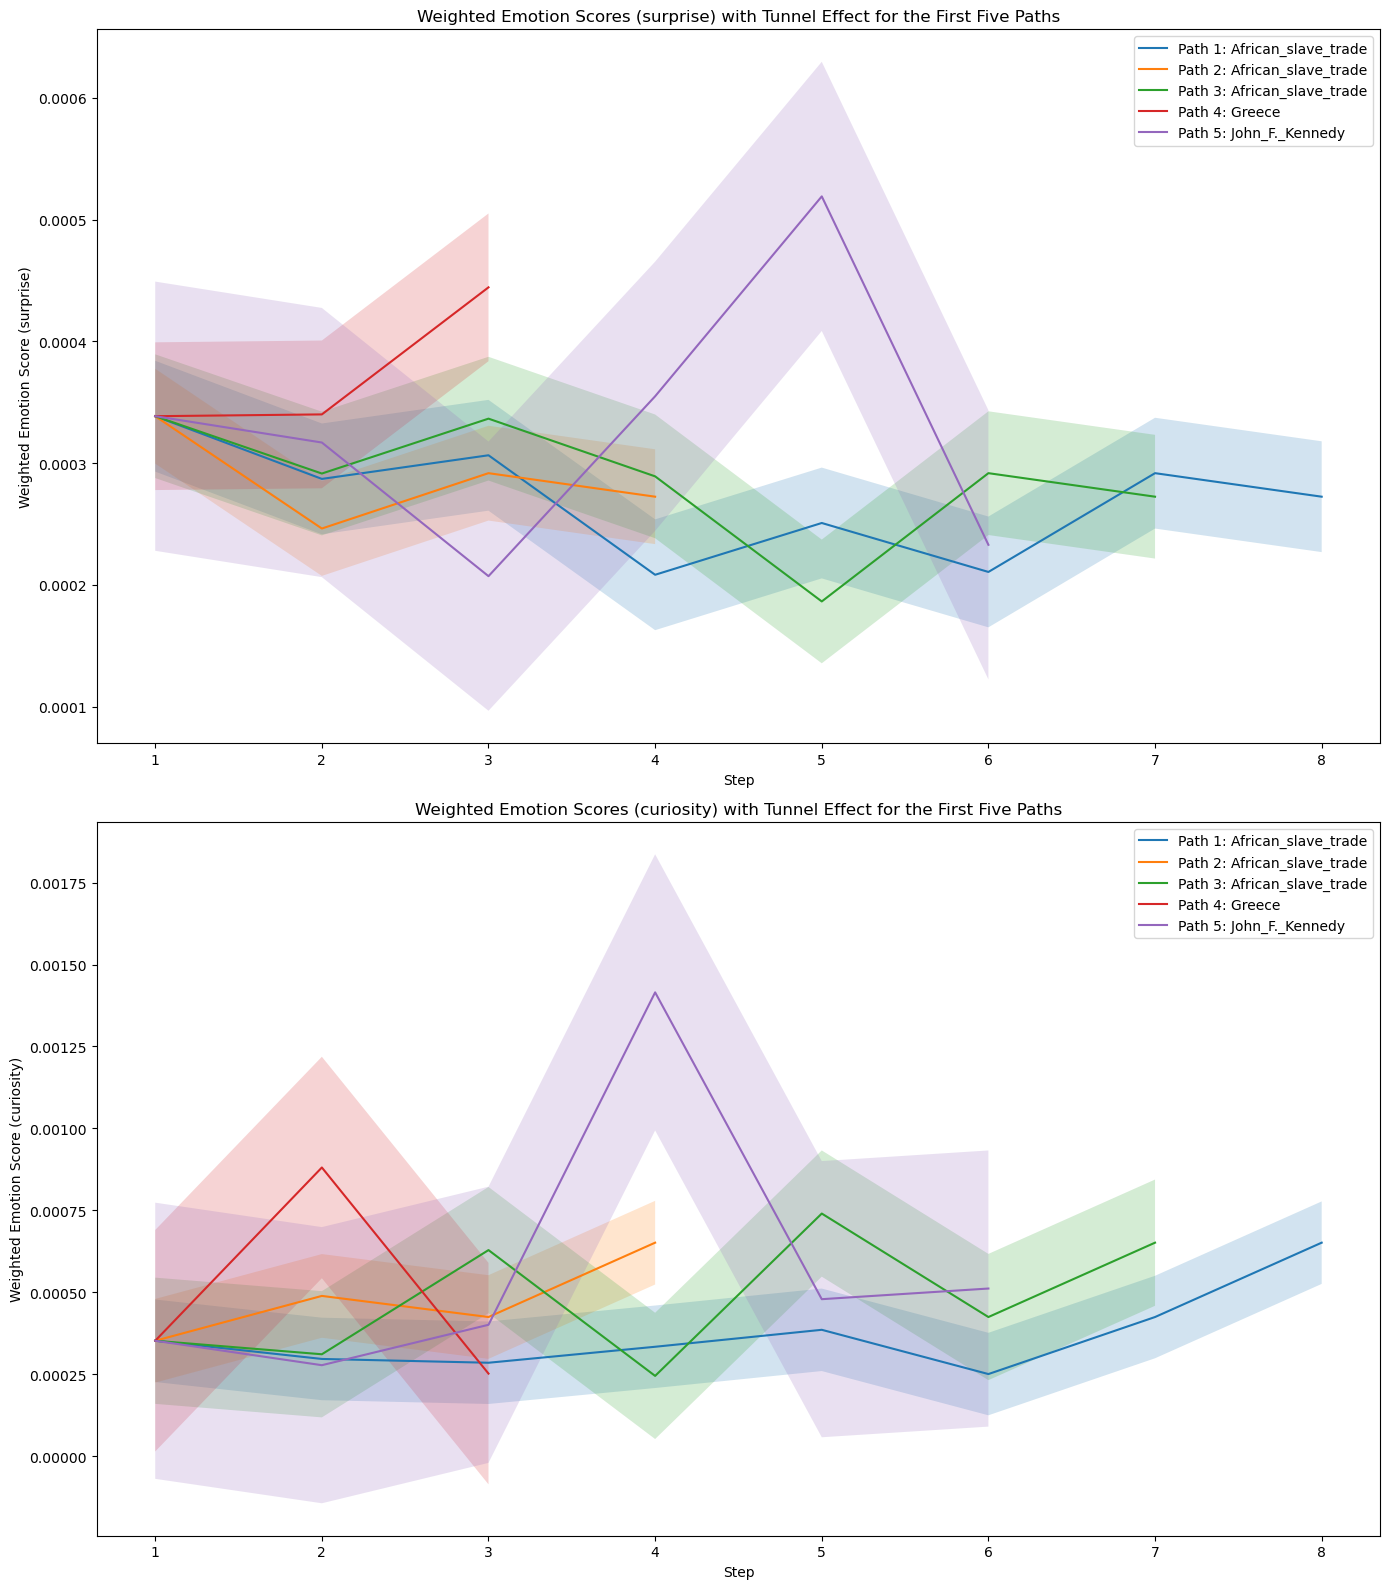

In [210]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have the dataframes for each emotion
first_five_paths_surprise = backtracking_path_weighted_emotions_surprise_df.head(5)
first_five_paths_curiosity = backtracking_path_weighted_emotions_curiosity_df.head(5)

# Function to plot paths for given dataframe, emotion label, and axis
def plot_emotion_paths(ax, paths_df, emotion_label):
    for index, row in paths_df.iterrows():
        target = row['target']
        steps = row.drop(labels=['target']).dropna().astype(float)

        # Calculate mean and standard deviation for error bars
        means = steps.mean()
        std_devs = steps.std()

        # Plot the path with error bars
        x = range(1, len(steps) + 1)
        y = steps
        ax.plot(x, y, label=f'Path {index + 1}: {target}')

        # Fill the area between the error margins
        ax.fill_between(x, y - std_devs, y + std_devs, alpha=0.2)

    # Add labels and title for the plot
    ax.set_xlabel('Step')
    ax.set_ylabel(f'Weighted Emotion Score ({emotion_label})')
    ax.set_title(f'Weighted Emotion Scores ({emotion_label}) with Tunnel Effect for the First Five Paths')
    ax.legend()

# Plotting both emotions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))

# Plot for Surprise
plot_emotion_paths(ax1, first_five_paths_surprise, 'surprise')

# Plot for Curiosity
plot_emotion_paths(ax2, first_five_paths_curiosity, 'curiosity')

# Show the plots
plt.tight_layout()
plt.show()

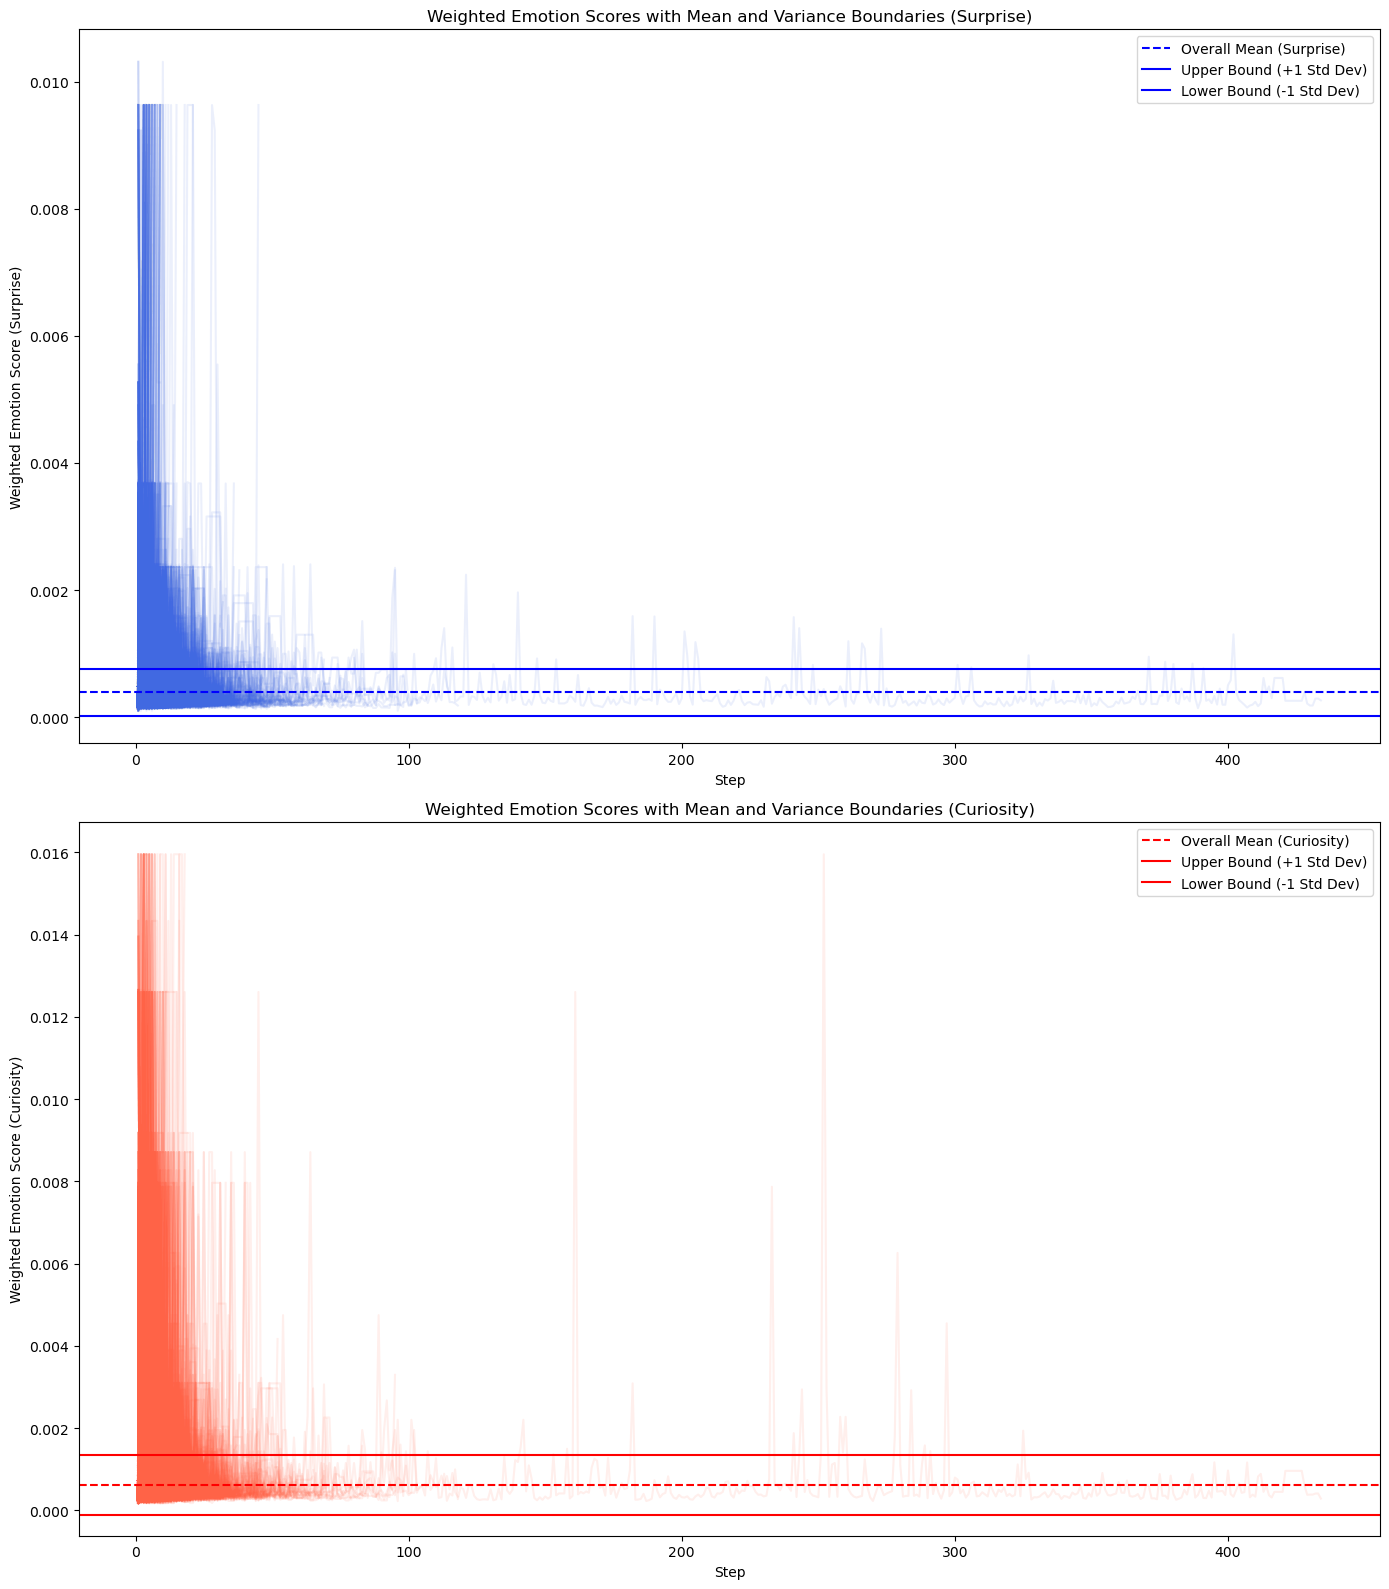

In [211]:
# Calculate mean and variance for each path in the dataframe
means_surprise = backtracking_path_weighted_emotions_surprise_df.apply(lambda row: row.drop(labels=['target']).dropna().mean(), axis=1)
variances_surprise = backtracking_path_weighted_emotions_surprise_df.apply(lambda row: row.drop(labels=['target']).dropna().var(), axis=1)

means_curiosity = backtracking_path_weighted_emotions_curiosity_df.apply(lambda row: row.drop(labels=['target']).dropna().mean(), axis=1)
variances_curiosity = backtracking_path_weighted_emotions_curiosity_df.apply(lambda row: row.drop(labels=['target']).dropna().var(), axis=1)

# Plot all paths with mean and variance as reference lines
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))

# Plot each path for surprise
for index, row in backtracking_path_weighted_emotions_surprise_df.iterrows():
    target = row['target']
    steps = row.drop(labels=['target']).dropna().astype(float)
    x = range(1, len(steps) + 1)
    y = steps
    ax1.plot(x, y, color='royalblue', alpha=0.1)

# Calculate overall mean and variance for plotting reference lines for surprise
overall_mean_surprise = means_surprise.mean()
overall_std_surprise = np.sqrt(variances_surprise.mean())

# Plot horizontal reference lines for surprise
ax1.axhline(overall_mean_surprise, color='b', linestyle='--', label='Overall Mean (Surprise)')
ax1.axhline(overall_mean_surprise + overall_std_surprise, color='b', linestyle='-', label='Upper Bound (+1 Std Dev)')
ax1.axhline(overall_mean_surprise - overall_std_surprise, color='b', linestyle='-', label='Lower Bound (-1 Std Dev)')

# Add labels and title for surprise
ax1.set_xlabel('Step')
ax1.set_ylabel('Weighted Emotion Score (Surprise)')
ax1.set_title('Weighted Emotion Scores with Mean and Variance Boundaries (Surprise)')
ax1.legend()

# Plot each path for curiosity
for index, row in backtracking_path_weighted_emotions_curiosity_df.iterrows():
    target = row['target']
    steps = row.drop(labels=['target']).dropna().astype(float)
    x = range(1, len(steps) + 1)
    y = steps
    ax2.plot(x, y, color='tomato', alpha=0.1)

# Calculate overall mean and variance for plotting reference lines for curiosity
overall_mean_curiosity = means_curiosity.mean()
overall_std_curiosity = np.sqrt(variances_curiosity.mean())

# Plot horizontal reference lines for curiosity
ax2.axhline(overall_mean_curiosity, color='r', linestyle='--', label='Overall Mean (Curiosity)')
ax2.axhline(overall_mean_curiosity + overall_std_curiosity, color='r', linestyle='-', label='Upper Bound (+1 Std Dev)')
ax2.axhline(overall_mean_curiosity - overall_std_curiosity, color='r', linestyle='-', label='Lower Bound (-1 Std Dev)')

# Add labels and title for curiosity
ax2.set_xlabel('Step')
ax2.set_ylabel('Weighted Emotion Score (Curiosity)')
ax2.set_title('Weighted Emotion Scores with Mean and Variance Boundaries (Curiosity)')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

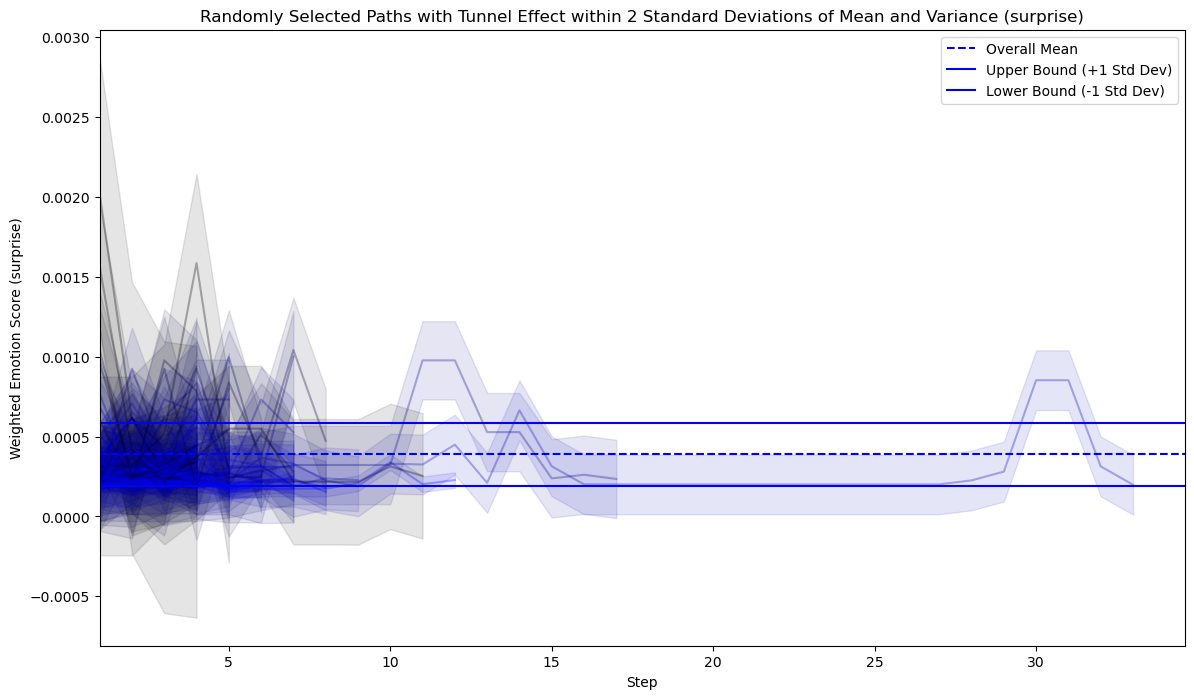

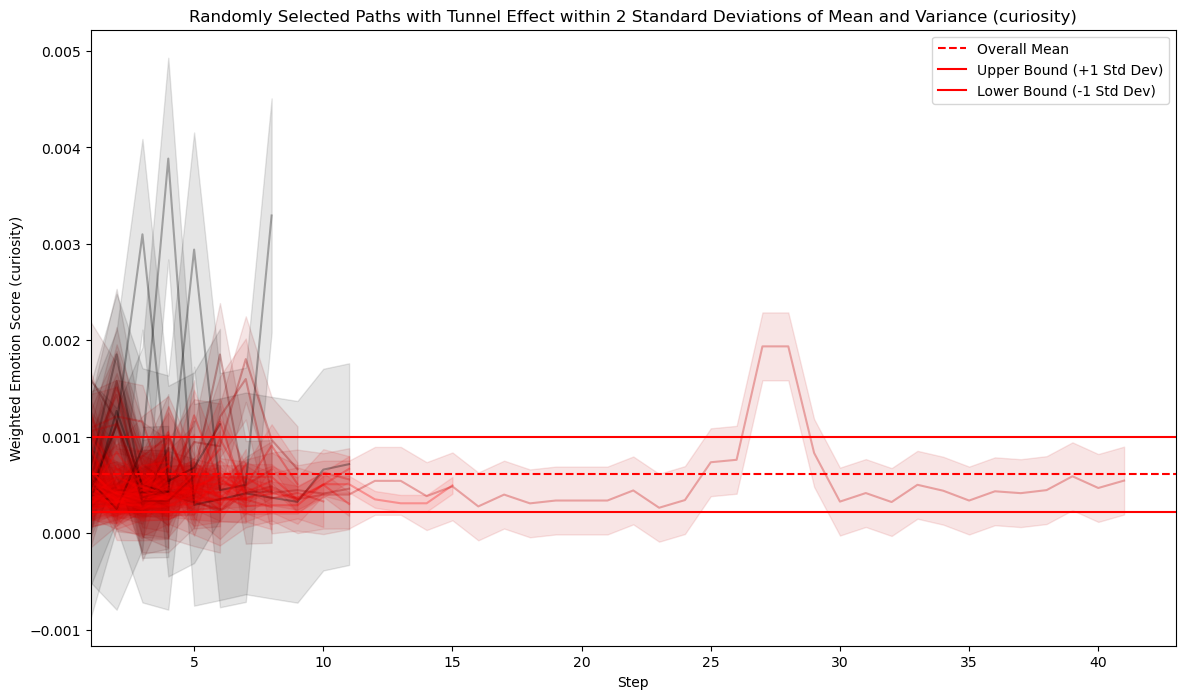

In [212]:
# Calculate mean and variance for each path in the dataframe
means_surprise = backtracking_path_weighted_emotions_surprise_df.apply(lambda row: row.drop(labels=['target']).dropna().mean(), axis=1)
variances_surprise = backtracking_path_weighted_emotions_surprise_df.apply(lambda row: row.drop(labels=['target']).dropna().var(), axis=1)

means_curiosity = backtracking_path_weighted_emotions_curiosity_df.apply(lambda row: row.drop(labels=['target']).dropna().mean(), axis=1)
variances_curiosity = backtracking_path_weighted_emotions_curiosity_df.apply(lambda row: row.drop(labels=['target']).dropna().var(), axis=1)

# Plot for surprise
overall_mean_surprise = means_surprise.mean()
overall_variance_surprise = variances_surprise.mean()
overall_std_mean_surprise = means_surprise.std()
overall_std_variance_surprise = variances_surprise.std()

filtered_indices_surprise = means_surprise[(means_surprise >= overall_mean_surprise - 2 * overall_std_mean_surprise) & (means_surprise <= overall_mean_surprise + 2 * overall_std_mean_surprise) &
                                           (variances_surprise >= overall_variance_surprise - 2 * overall_std_variance_surprise) & (variances_surprise <= overall_variance_surprise + 2 * overall_std_variance_surprise)].index

valid_indices_surprise = backtracking_path_weighted_emotions_surprise_df.loc[filtered_indices_surprise].apply(lambda row: row.dropna().shape[0] >= 5, axis=1)
filtered_indices_surprise = filtered_indices_surprise[valid_indices_surprise]

random_paths_surprise = backtracking_path_weighted_emotions_surprise_df.loc[filtered_indices_surprise].sample(n=min(50, len(filtered_indices_surprise)), random_state=42)

fig, ax = plt.subplots(figsize=(14, 8))

for index, row in random_paths_surprise.iterrows():
    target = row['target']
    steps = row.drop(labels=['target']).dropna().astype(float)
    x = np.arange(1, len(steps) + 1)
    y = steps

    means = steps.mean()
    std_devs = steps.std()
    variance = steps.var()

    color_intensity = min(1, variance / overall_variance_surprise)
    color = (0, 0, 1 - color_intensity, 1)

    ax.plot(x, y, alpha=0.3, color=color)
    ax.fill_between(x, y - std_devs, y + std_devs, alpha=0.1, color=color)

ax.axhline(overall_mean_surprise, color='b', linestyle='--', label='Overall Mean')
ax.axhline(overall_mean_surprise + overall_std_mean_surprise, color='b', linestyle='-', label='Upper Bound (+1 Std Dev)')
ax.axhline(overall_mean_surprise - overall_std_mean_surprise, color='b', linestyle='-', label='Lower Bound (-1 Std Dev)')

ax.set_xlim(left=1)
ax.set_xlabel('Step')
ax.set_ylabel('Weighted Emotion Score (surprise)')
ax.set_title('Randomly Selected Paths with Tunnel Effect within 2 Standard Deviations of Mean and Variance (surprise)')
ax.legend()

plt.show()

# Plot for curiosity
overall_mean_curiosity = means_curiosity.mean()
overall_variance_curiosity = variances_curiosity.mean()
overall_std_mean_curiosity = means_curiosity.std()
overall_std_variance_curiosity = variances_curiosity.std()

filtered_indices_curiosity = means_curiosity[(means_curiosity >= overall_mean_curiosity - 2 * overall_std_mean_curiosity) & (means_curiosity <= overall_mean_curiosity + 2 * overall_std_mean_curiosity) &
                                             (variances_curiosity >= overall_variance_curiosity - 2 * overall_std_variance_curiosity) & (variances_curiosity <= overall_variance_curiosity + 2 * overall_std_variance_curiosity)].index

valid_indices_curiosity = backtracking_path_weighted_emotions_curiosity_df.loc[filtered_indices_curiosity].apply(lambda row: row.dropna().shape[0] >= 5, axis=1)
filtered_indices_curiosity = filtered_indices_curiosity[valid_indices_curiosity]

random_paths_curiosity = backtracking_path_weighted_emotions_curiosity_df.loc[filtered_indices_curiosity].sample(n=min(50, len(filtered_indices_curiosity)), random_state=42)

fig, ax = plt.subplots(figsize=(14, 8))

for index, row in random_paths_curiosity.iterrows():
    target = row['target']
    steps = row.drop(labels=['target']).dropna().astype(float)
    x = np.arange(1, len(steps) + 1)
    y = steps

    means = steps.mean()
    std_devs = steps.std()
    variance = steps.var()

    color_intensity = min(1, variance / overall_variance_curiosity)
    color = (1 - color_intensity, 0, 0, 1)

    ax.plot(x, y, alpha=0.3, color=color)
    ax.fill_between(x, y - std_devs, y + std_devs, alpha=0.1, color=color)

ax.axhline(overall_mean_curiosity, color='r', linestyle='--', label='Overall Mean')
ax.axhline(overall_mean_curiosity + overall_std_mean_curiosity, color='r', linestyle='-', label='Upper Bound (+1 Std Dev)')
ax.axhline(overall_mean_curiosity - overall_std_mean_curiosity, color='r', linestyle='-', label='Lower Bound (-1 Std Dev)')

ax.set_xlim(left=1)
ax.set_xlabel('Step')
ax.set_ylabel('Weighted Emotion Score (curiosity)')
ax.set_title('Randomly Selected Paths with Tunnel Effect within 2 Standard Deviations of Mean and Variance (curiosity)')
ax.legend()

plt.show()


### Visulization 2 Correlation of Two Emotions

In [218]:
import pandas as pd

# Function to calculate the correlation between two emotions for a single path
def calculate_emotion_correlation(path_index, surprise_df, curiosity_df):
    surprise_values = surprise_df.loc[path_index].drop(labels=['target']).dropna().astype(float)
    curiosity_values = curiosity_df.loc[path_index].drop(labels=['target']).dropna().astype(float)
    
    if len(surprise_values) > 1 and len(curiosity_values) > 1:
        correlation = surprise_values.corr(curiosity_values)
    else:
        correlation = None  # Not enough data to calculate correlation
    
    return correlation

# Create a list to store the correlation results
correlation_data = []

# Iterate over each path and calculate the correlation
for path_index in backtracking_path_weighted_emotions_surprise_df.index:
    correlation = calculate_emotion_correlation(path_index, backtracking_path_weighted_emotions_surprise_df, backtracking_path_weighted_emotions_curiosity_df)
    num_steps = backtracking_path_weighted_emotions_surprise_df.loc[path_index].drop(labels=['target']).dropna().shape[0]
    
    if correlation is not None:  # Only add rows with valid correlation values
        correlation_data.append({'path_index': path_index, 'correlation': correlation, 'num_steps': num_steps})

# Convert the list of dictionaries to a DataFrame
correlation_df = pd.DataFrame(correlation_data)

print(correlation_df.head())


/var/folders/ww/0cs7zdg14jsc23xxm7ngz1fc0000gn/T/ipykernel_1385/3597918652.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_df = pd.concat([correlation_df, pd.DataFrame({'path_index': [path_index], 'correlation': [correlation], 'num_steps': [num_steps]})], ignore_index=True)


  path_index  correlation num_steps
0          0     0.132568         8
1          1    -0.651501         4
2          2    -0.501131         7
3          3    -0.613398         3
4          4     0.138638         6


In [232]:
# Group the correlation DataFrame by 'num_steps' and calculate statistics for each group
grouped_stats = correlation_df.groupby('num_steps').agg(
    count=('correlation', 'count'),
    mean_correlation=('correlation', 'mean'),
    min_correlation=('correlation', 'min'),
    max_correlation=('correlation', 'max'),
    std_correlation=('correlation', 'std')
).reset_index()
grouped_stats = grouped_stats.sort_values(by='num_steps')
print(grouped_stats)

# Extract the numbers for the distribution of count by number of steps
distribution_counts = grouped_stats[['num_steps', 'count']].to_dict(orient='list')
print(distribution_counts)


    num_steps  count  mean_correlation  min_correlation  max_correlation  \
0           2   3424          0.136098        -1.000000         1.000000   
1           3   8558          0.117370        -1.000000         1.000000   
2           4  10941          0.133938        -1.000000         1.000000   
3           5   8137          0.135770        -0.998878         0.999859   
4           6   5868          0.145844        -0.995965         0.999642   
..        ...    ...               ...              ...              ...   
72         95      2          0.130041        -0.042159         0.302240   
73         98      1          0.239453         0.239453         0.239453   
74        103      1          0.000140         0.000140         0.000140   
75        118      1          0.101036         0.101036         0.101036   
76        434      1          0.042685         0.042685         0.042685   

    std_correlation  
0          0.990840  
1          0.704963  
2          0.574210  

In [236]:
# Drop rows where the count is less than 10
grouped_stats_filtered = grouped_stats[grouped_stats['count'] >= 10]


    num_steps  count  mean_correlation  min_correlation  max_correlation  \
0           2   3424          0.136098        -1.000000         1.000000   
1           3   8558          0.117370        -1.000000         1.000000   
2           4  10941          0.133938        -1.000000         1.000000   
3           5   8137          0.135770        -0.998878         0.999859   
4           6   5868          0.145844        -0.995965         0.999642   
5           7   3954          0.137701        -0.992755         0.998786   
6           8   2650          0.149083        -0.950864         0.998775   
7           9   1713          0.143275        -0.984511         0.997779   
8          10   1256          0.151168        -0.833778         0.998849   
9          11    867          0.146424        -0.749793         0.994770   
10         12    623          0.136521        -0.736726         0.988714   
11         13    462          0.114081        -0.815387         0.960674   
12         1

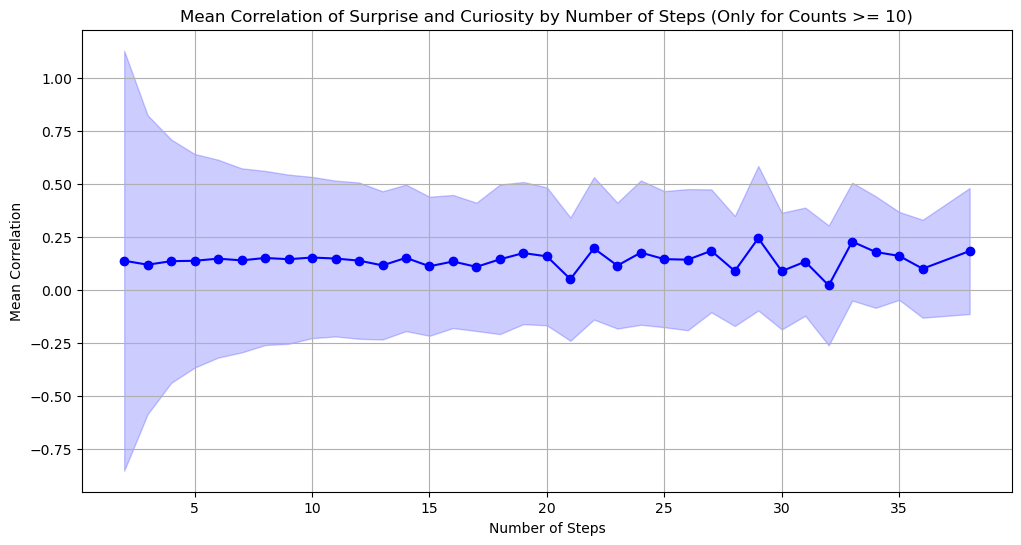

In [238]:

# Plot mean correlation by number of steps
plt.figure(figsize=(12, 6))
plt.plot(grouped_stats_filtered['num_steps'], grouped_stats_filtered['mean_correlation'], marker='o', linestyle='-', color='b')
plt.fill_between(grouped_stats_filtered['num_steps'], 
				 grouped_stats_filtered['mean_correlation'] - grouped_stats_filtered['std_correlation'], 
				 grouped_stats_filtered['mean_correlation'] + grouped_stats_filtered['std_correlation'], 
				 color='b', alpha=0.2)

# Add labels and title
plt.xlabel('Number of Steps')
plt.ylabel('Mean Correlation')
plt.title('Mean Correlation of Surprise and Curiosity by Number of Steps (Only for Counts >= 10)')
plt.grid(True)
plt.show()

In [240]:
import pandas as pd
from scipy.stats import pearsonr

# Function to calculate the correlation and p-value between two emotions for a single path
def calculate_emotion_correlation(path_index, surprise_df, curiosity_df):
    surprise_values = surprise_df.loc[path_index].drop(labels=['target']).dropna().astype(float)
    curiosity_values = curiosity_df.loc[path_index].drop(labels=['target']).dropna().astype(float)
    
    if len(surprise_values) > 1 and len(curiosity_values) > 1:
        correlation, p_value = pearsonr(surprise_values, curiosity_values)
    else:
        correlation = None  # Not enough data to calculate correlation
        p_value = None
    
    return correlation, p_value

# Create a list to store the correlation results
correlation_data = []

# Iterate over each path and calculate the correlation
for path_index in backtracking_path_weighted_emotions_surprise_df.index:
    correlation, p_value = calculate_emotion_correlation(path_index, backtracking_path_weighted_emotions_surprise_df, backtracking_path_weighted_emotions_curiosity_df)
    num_steps = backtracking_path_weighted_emotions_surprise_df.loc[path_index].drop(labels=['target']).dropna().shape[0]
    
    if correlation is not None:  # Only add rows with valid correlation values
        correlation_data.append({'path_index': path_index, 'correlation': correlation, 'p_value': p_value, 'num_steps': num_steps})

# Convert the list of dictionaries to a DataFrame
correlation_df = pd.DataFrame(correlation_data)

# Calculate the mean and variance of the correlation column
mean_correlation = correlation_df['correlation'].mean()
variance_correlation = correlation_df['correlation'].var()

print("Correlation DataFrame:")
print(correlation_df.head())
print("\nMean Correlation:", mean_correlation)
print("Variance of Correlation:", variance_correlation)

# Print p-values as well
print("\nP-Values:")
print(correlation_df['p_value'].mean())


Correlation DataFrame:
   path_index  correlation   p_value  num_steps
0           0     0.132568  0.754332          8
1           1    -0.651501  0.348499          4
2           2    -0.501131  0.251924          7
3           3    -0.613398  0.579604          3
4           4     0.138638  0.793375          6

Mean Correlation: 0.1349301121490291
Variance of Correlation: 0.3303757638465521

P-Values:
0    0.754332
1    0.348499
2    0.251924
3    0.579604
4    0.793375
Name: p_value, dtype: float64


In [241]:
print(correlation_df['p_value'].mean())

0.5177463539192172


### Visulization 3 Emotion Jump